In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])

In [4]:
dataset.shape

(1442, 8)

In [5]:
dataset.shape[0]

1442

In [6]:
dataset.shape[1]

8

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 5, 16)             64        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 16)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 77        
Total params: 471
Trainable params: 471
Non-trainable params: 0
_________________________________________________________________
None
actual.shape[0]:46, actual.shape[1]:7
cnn: [400.800] 429.3, 391.4, 346.6, 395.3, 404.1, 320.0, 494.9



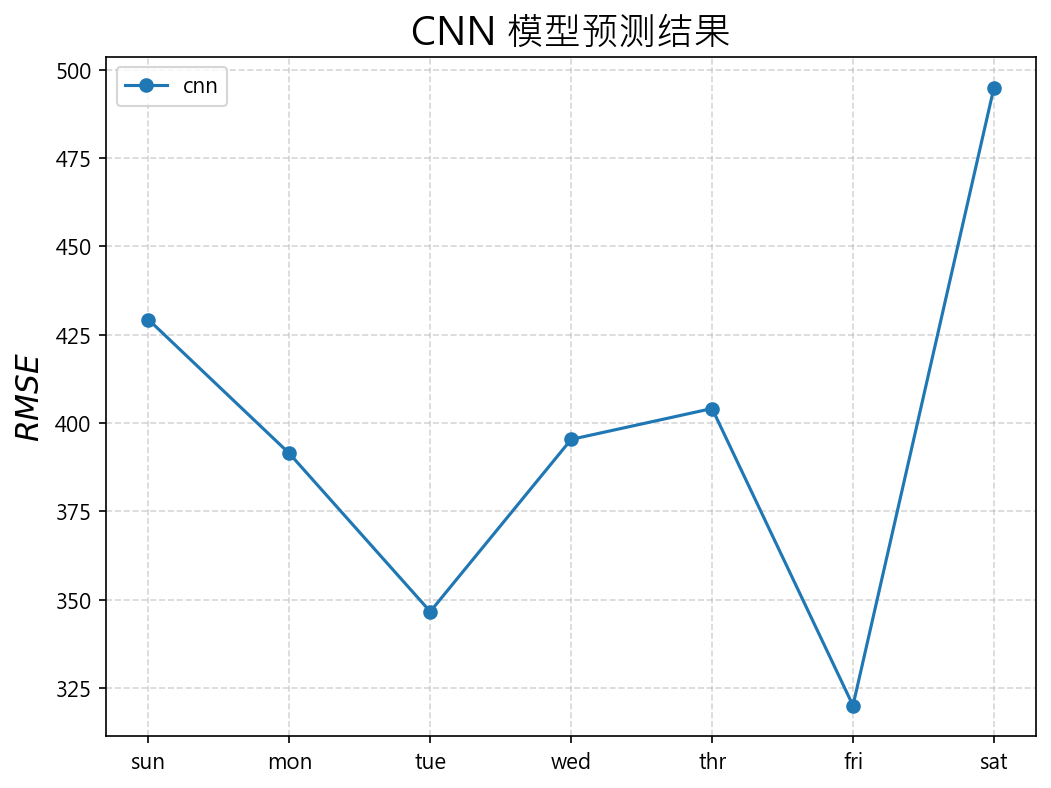

----------------------------------洗发水推荐：霸王---------------------------------


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D,MaxPooling1D

def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 训练数据以滑动步长1截取
            train_seq = data[in_start:in_end, 0]
            train_seq = train_seq.reshape((len(train_seq), 1))
            X.append(train_seq)
            y.append(data[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)

def cnn_model(train, sw_width, in_start=0, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    该函数定义 1D CNN 模型
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', 
                     input_shape=(n_timesteps, n_features)))
    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(units=n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model

def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, len(input_x), 1)) # 重塑形状[1, sw_width, 1]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('CNN 模型预测结果',  size=18)
    plt.legend()
    plt.show()
    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = cnn_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)
    
    print('----------------------------------洗发水推荐：霸王---------------------------------')
    
if __name__ == '__main__':
    
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])
    
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'cnn'
    
    sliding_window_width= 7 #14
    input_sequence_start=0
    
    epochs_num=20
    batch_size_set=4
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)

In [7]:
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011
...,...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0,16924.600023
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0,16352.266679
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0,13769.466664


In [ ]:
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    截取所有特征
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 因为是for循环，所以滑动窗口的滑动步长为1；想调整滑动步长可以通过yield实现，后边的文章会讲；
            X.append(data[in_start:in_end, :]) # 截取窗口宽度数量的采样点的全部8个特征
            y.append(data[in_end:out_end, 0]) # 截取样本之后7个时间步长的总有功功耗（截取一个单列片段，有7个元素）
        in_start += 1
        
    return np.array(X), np.array(y)

In [10]:
train, test = split_dataset(dataset.values)

In [11]:
train.shape

(159, 7, 8)

In [12]:
test.shape

(46, 7, 8)

In [ ]:
def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    多个特征
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, :] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) # 重塑形状为[1, sw_width, n]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

In [ ]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
    input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
def cnn_model(train, sw_width, in_start=0, verbose=0, epochs=20, batch_size=16):
    '''
    该函数定义 1D CNN 模型
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', 
                     input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(units=n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 12, 32)            800       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 32)            3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3, 16)             1552      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

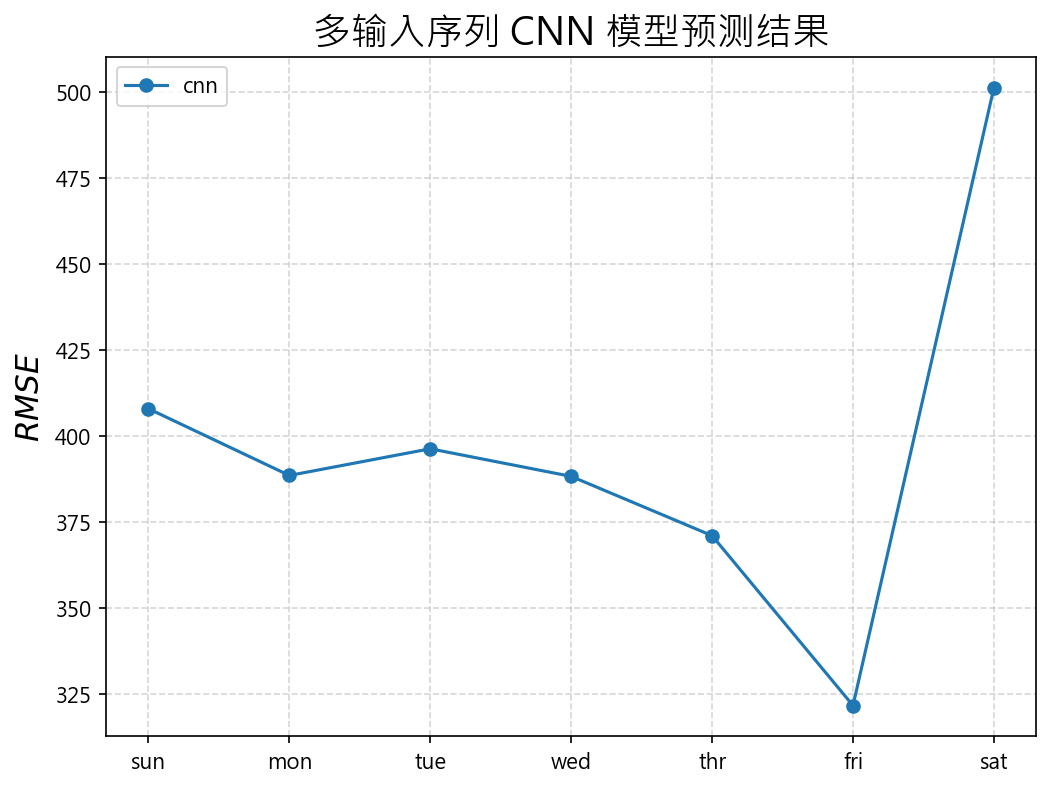

----------------------------------洗发水推荐：康王---------------------------------


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D,MaxPooling1D

def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    截取所有特征
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 因为是for循环，所以滑动窗口的滑动步长为1；想调整滑动步长可以通过yield实现，后边的文章会讲；
            X.append(data[in_start:in_end, :]) # 截取窗口宽度数量的采样点的全部8个特征
            y.append(data[in_end:out_end, 0]) # 截取样本之后7个时间步长的总有功功耗（截取一个单列片段，有7个元素）
        in_start += 1
        
    return np.array(X), np.array(y)

def multi_input_cnn_model(train, sw_width, in_start=0, verbose=0, epochs=20, batch_size=16):
    '''
    该函数定义 多输入序列 CNN 模型
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', 
                     input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(units=n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(train_x, train_y,
              epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    多个特征
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, :] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) # 重塑形状为[1, sw_width, n]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('多输入序列 CNN 模型预测结果',  size=18)
    plt.legend()
    plt.show()
    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = multi_input_cnn_model(train, sw_width, in_start, verbose, epochs, batch_size)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)
    
    print('----------------------------------洗发水推荐：康王---------------------------------')
    
if __name__ == '__main__':
    
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])
    
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'cnn'
    
    sliding_window_width=14
    input_sequence_start=0
    
    epochs_num=80
    batch_size_set=16
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)

train.shape:(159, 7, 8), test.shape:(46, 7, 8)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 14, 1)]      0                                            
______________________________________________

actual.shape[0]:46, actual.shape[1]:7
cnn: [492.451] 575.9, 437.3, 498.6, 473.7, 511.1, 417.1, 516.2



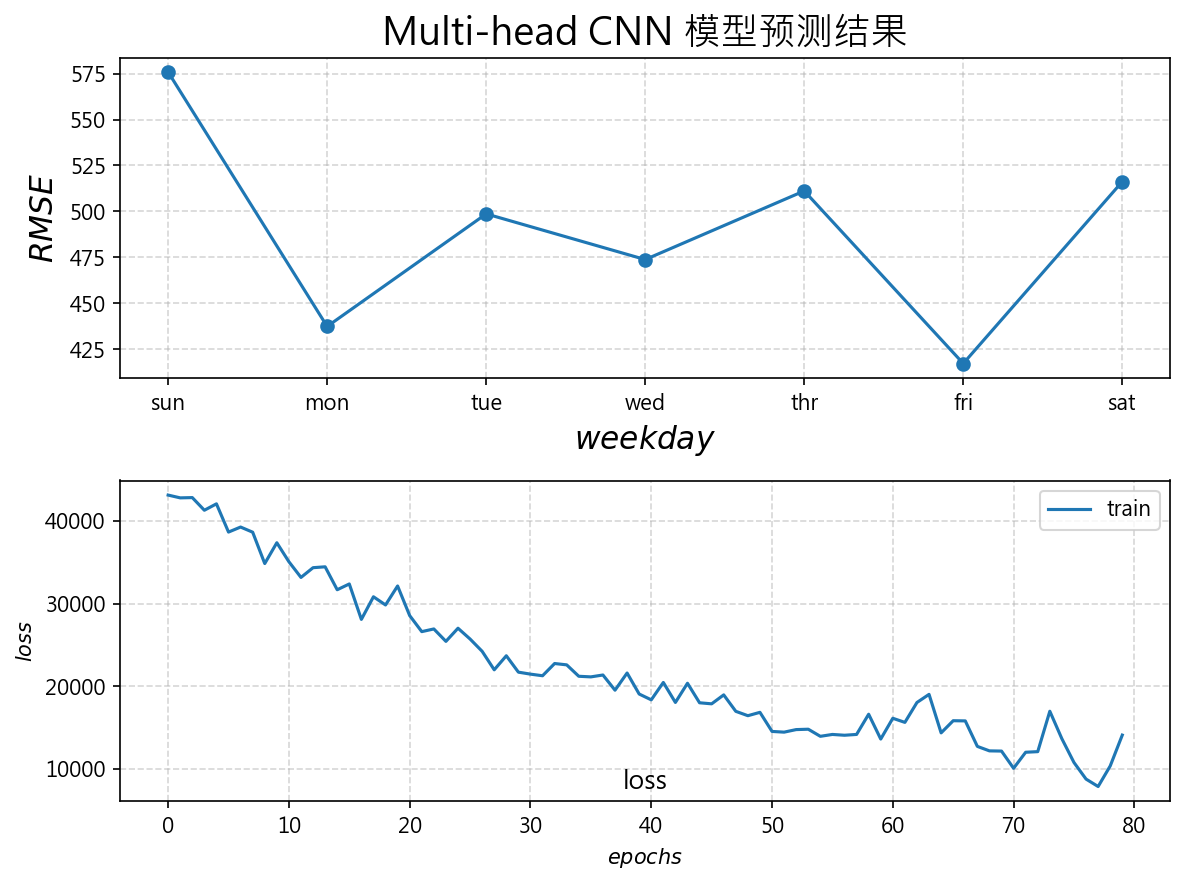

----------------------------------洗发水推荐：康王+霸王---------------------------------


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    print('train.shape:{}, test.shape:{}\n'.format(train.shape, test.shape))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))
    
def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    截取所有特征
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end <= len(data):
            # 因为是for循环，所以滑动窗口的滑动步长为1；想调整滑动步长可以通过yield实现，后边的文章会讲；
            X.append(data[in_start:in_end, :]) # 截取窗口宽度数量的采样点的全部8个特征
            y.append(data[in_end:out_end, 0]) # 截取样本之后7个时间步长的总有功功耗（截取一个单列片段，有7个元素）
        
        in_start += 1 # 实现简单的滑动窗口，滑动步长为1
        
    return np.array(X), np.array(y)

def multi_head_cnn_model(train, sw_width, in_start=0, verbose=0, epochs=20, batch_size=16):
    '''
    该函数定义 Multi-head CNN 模型
    '''
    train_x, train_y = sliding_window(train, sw_width)
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    in_layers, out_layers = [], [] # 用于存放每个特征序列的CNN子模型
    for i in range(n_features):
        inputs = Input(shape=(n_timesteps, 1))
        
        conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
        conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
        pool1 = MaxPooling1D(pool_size=2)(conv2)
        flat = Flatten()(pool1)
        in_layers.append(inputs)
        out_layers.append(flat)

    merged = concatenate(out_layers) # 合并八个CNN子模型
    
    dense1 = Dense(200, activation='relu')(merged) # 全连接层对上一层输出特征进行解释
    dense2 = Dense(100, activation='relu')(dense1)
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs)

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    plot_model(model, to_file='multi-head-cnn-energy-usage-prediction.png', show_shapes=True, show_layer_names=True, dpi=300)
    
    input_data = [train_x[:,:,i].reshape((train_x.shape[0], n_timesteps, 1)) for i in range(n_features)]
    
    model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    history = model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

    return model, history 

def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    多个特征
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, :] # 获取输入数据的最后一周的数据
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]# 8个形状为[1, sw_width, 1]的列表
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name, history):
    '''
    该函数实现绘制RMSE曲线图和训练损失图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.subplot(2,1,1)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlabel(r'$weekday$', size=15)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('Multi-head CNN 模型预测结果',  size=18)
    
    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label='train')
    plt.title('loss', y=0, loc='center')
    plt.xlabel('$epochs$', size=10)
    plt.ylabel('$loss$', size=10)
    plt.legend()
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    
def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型 
    model, history = multi_head_cnn_model(train, sw_width, in_start, verbose, epochs, batch_size)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘制RMSE图和训练损失图
    model_plot(score, scores, days, name, history)

    
    print('----------------------------------洗发水推荐：康王+霸王---------------------------------')
    
if __name__ == '__main__':
    
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])
    
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'cnn'
    
    sliding_window_width=14
    input_sequence_start=0
    
    epochs_num=80 #25
    batch_size_set=16
    verbose_set=0
    
    
    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)